In [1]:
import os
import re
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import keras
import tensorflow as tf
from __future__ import print_function
import argparse
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy import stats
import matplotlib.pyplot as plt

# FASTA parser requires Biopython
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Retrieve protein alignment file
if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
        
# Retrieve file with experimental measurements
if not os.path.exists('BLAT_ECOLX_Ranganathan2015.csv'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
        


     |████████████████████████████████| 2.3 MB 18.2 MB/s 
--2022-01-19 10:52:53--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2441075 (2.3M)
Saving to: ‘BLAT_ECOLX_1_b0.5_labeled.fasta’

BLAT_ECOLX_1_b0.5_l 100%[===================>]   2.33M  3.36MB/s    in 0.7s    

2022-01-19 10:52:54 (3.36 MB/s) - ‘BLAT_ECOLX_1_b0.5_labeled.fasta’ saved [2441075/2441075]

--2022-01-19 10:52:54--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M  1.94MB/s 

Following Code processes the Data and loads the two respective data loaders


In [2]:
# Mapping from amino acids to integers
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22}
aa1 = "ACDEFGHIKLMNPQRSTVWYXZ-"

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']

# Options
batch_size = 16

def get_data(data_filename, calc_weights=False, weights_similarity_threshold=0.8):

    '''Create dataset from FASTA filename'''
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)       
        seqs.append(np.array([(aa1_to_index[aa]) for aa in str(record.seq).upper().replace('.', '-')]))
        
        label = label_re.search(record.description).group(1)
        # Only use most common classes
        if label not in phyla:
            label = 'Other'
        labels.append(label)
                
    seqs_int = torch.from_numpy(np.vstack(seqs))
    seqs = torch.from_numpy(np.vstack(seqs)).float()
    
    labels = np.array(labels)
    
    phyla_lookup_table, phyla_idx = np.unique(labels, return_inverse=True)

    # Normal, unscaled dataset in the range of 0 - 22
    dataset_integers = torch.utils.data.TensorDataset(*[seqs_int, torch.from_numpy(phyla_idx)])
    
    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')

        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0

        weights = []
        weight_batch_size = 1000
        
        # Correct format
        flat_one_hot = one_hot.flatten(1).float()
        dataset = torch.utils.data.TensorDataset(*[flat_one_hot, torch.from_numpy(phyla_idx)])

        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(weights_similarity_threshold).sum(1).float()
            weights.append(w)
            
        weights = torch.cat(weights)
        neff = weights.sum()


    return dataset, weights, dataset_integers


dataset, weights, dataset_integers = get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

# Creating two different dataloader
# dataloader_with_weights uses the sampler to implement the weighting
dataloader_no_weights = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_with_weights = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, sampler=sampler)


## Task 1: Creating the VAE


In [3]:
# Own implementation of the variational autoencoder : 

torch.manual_seed(1)
cuda2 = False
device = torch.device("cuda" if cuda2 else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {}

epochs2 = 2 # About 20 is sufficent

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Since we use one-hot-encoding, the input dimension is 23 * 263 = 6049
        self.fc1 = nn.Linear(6049, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2
        self.fc3 = nn.Linear(2, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 6049)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        # Using torch.distributions
        return torch.distributions.normal.Normal(loc = self.fc21(h2), scale = torch.exp(0.5*self.fc22(h2)))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        gauss = self.encode(x.view(-1, 6049))
        # We sample z from the latent space using a Gaussian distribution
        z = gauss.rsample()
        return self.decode(z), gauss.mean, gauss.stddev

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # Using Binary Cross Entropy as the loss function
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 6049), reduction='sum')
    q_z = torch.distributions.normal.Normal(loc = mu, scale = logvar)
    p_z = torch.distributions.normal.Normal(torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale))
    KLD = torch.distributions.kl_divergence(q_z, p_z).sum()
    return BCE + KLD # -ELBO


def train(epoch,model, weights_bool):
    model.train()
    train_loss = 0
    if weights_bool:
      dataloader = dataloader_with_weights
    else:
      dataloader = dataloader_no_weights
    
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))




In [4]:
# Training a baseline model (task 1 - 3)
print("Base-model")
model_no_weights = VAE().to(device)
optimizer = optim.Adam(model_no_weights.parameters(), lr=1e-3)
for epoch in range(1, epochs2 + 1):
    train(epoch, model_no_weights, False)

print("Weighted-model")
# Training a weighted model (task 4)
model_weights = VAE().to(device)
optimizer = optim.Adam(model_weights.parameters(), lr=1e-3)
for epoch in range(1, epochs2 + 1):
    train(epoch, model_weights, True)
  

Base-model
====> Epoch: 1 Average loss: 626.6815
====> Epoch: 2 Average loss: 461.6168
Weighted-model
====> Epoch: 1 Average loss: 719.0540
====> Epoch: 2 Average loss: 581.5549


## Task 2: Plotting the latent space

In [5]:
# M = 7844, since the dataset feature 7844 rows
# N = 2, since we set the latent space = 2
def create_results(model, weights_bool):
  results = torch.zeros((7844,2))
  all_labels = torch.empty(0)
  l = 0
  if weights_bool:
    dataloader = dataloader_with_weights
  else:
    dataloader = dataloader_no_weights
  for x,y in dataloader:
    all_labels = torch.cat((all_labels, y))
    for sequence in x:
      transformed_sequence = model.encode(sequence).mean
      results[l] = transformed_sequence
      l += 1
    group = all_labels
  return results.detach().numpy(), group

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}


def plot(results_for_plot,group, title):
  scatter_x = results_for_plot[:,0]
  scatter_y = results_for_plot[:,1]
  fig, ax = plt.subplots()
  for g in np.unique(group):
      ix = np.where(group == g)
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = phyla[int(g)], s = .1)
  ax.legend(bbox_to_anchor=[1,1],markerscale = 10)
  ax.set_xlabel('z_1')
  ax.set_ylabel('z_2')
  ax.set_title('β-lactamase')
  plt.show()

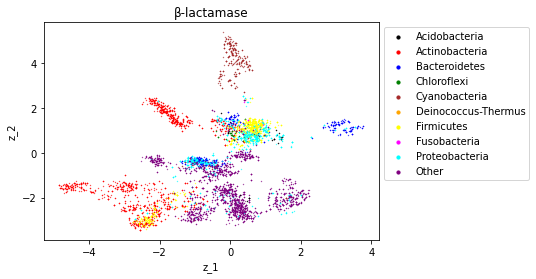

In [6]:
results_for_plot_weights,group = create_results(model_weights, True)
plot(results_for_plot_weights,group, '')

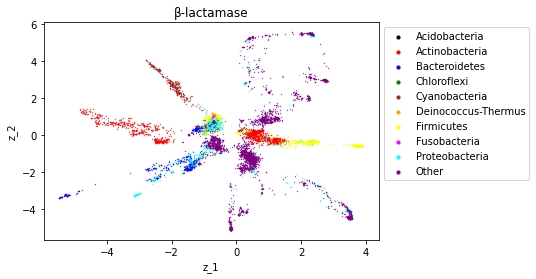

In [7]:
results_for_plot_no_weights,group = create_results(model_no_weights, False)
plot(results_for_plot_no_weights,group, '')

In [8]:
def read_experimental_data(filename, alignment_data, measurement_col_name = '2500', sequence_offset=0):
    '''Read experimental data from csv file, and check that amino acid match those 
       in the first sequence of the alignment.
       
       measurement_col_name specifies which column in the csv file contains the experimental 
       observation. In our case, this is the one called 2500.
       
       sequence_offset is used in case there is an overall offset between the
       indices in the two files.
       '''
    
    measurement_df = pd.read_csv(filename, delimiter=',', usecols=['mutant', measurement_col_name])
    
    wt_sequence, wt_label = alignment_data[0]
    zero_index = None
    
    experimental_data = {}
    for idx, entry in measurement_df.iterrows():
        mutant_from, position, mutant_to = entry['mutant'][:1],int(entry['mutant'][1:-1]),entry['mutant'][-1:]  
        
        # Use index of first entry as offset (keep track of this in case 
        # there are index gaps in experimental data)
        if zero_index is None:
            zero_index = position
            
        # Corresponding position in our alignment
        seq_position = position-zero_index+sequence_offset
       
        # Make sure that two two inputs agree on the indices: the 
        # amino acids in the first entry of the alignment should be 
        # identical to those in the experimental file.
        
        assert mutant_from == aa1[wt_sequence[seq_position]]  
        
        if seq_position not in experimental_data:
            experimental_data[seq_position] = {}
        
        # Check that there is only a single experimental value for mutant
        assert mutant_to not in experimental_data[seq_position]
        
        experimental_data[seq_position]['pos'] = seq_position
        experimental_data[seq_position]['WT'] = mutant_from
        experimental_data[seq_position][mutant_to] = entry[measurement_col_name]
    
    experimental_data = pd.DataFrame(experimental_data).transpose().set_index(['pos', 'WT'])
    return experimental_data, wt_sequence
        
        
experimental_data,wt_sequence = read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset_integers)



## 3. Calculating the Spearman-Value

In [9]:
# Creating a one-hot-encoding of the wildtype-sequence

one_hot_wt1 = F.one_hot(wt_sequence[:len(wt_sequence)//2].long()).bool()
one_hot_wt2 = F.one_hot(wt_sequence[len(wt_sequence)//2:].long()).bool()
one_hot_wt = torch.cat([one_hot_wt1, one_hot_wt2]).to('cuda' if torch.cuda.is_available() else 'cpu')
one_hot_wt = torch.cat((one_hot_wt,torch.zeros(263,3)), 1).flatten(0)

def compute_spearman(model, iterations):
  # For each of the entries in the dataframe above, you should calculate
  # the corresponding difference in ELBO from your VAE, and then finally
  # calculate a Spearman correlation between the two.

  # Creating a matrix which stores all our elbo values 
  # which we retrieve from our VAE for different mutations 
  elbo_matrix = np.zeros([263, 23]) 

  # Calculating the initial_elbo of our wildtype sequence
  recon_batch, mu, logvar = model(one_hot_wt)
  elbo_initial_sequence = loss_function(recon_batch, one_hot_wt, mu, logvar)

  i = 0
  # You can iterate over all experimental values like this:
  for (position, mutant_from), row in experimental_data.iterrows():
      j =0
      #print(position, mutant_from)   # mutant from is the wild type (wt)
      for mutant_to, exp_value in row.iteritems():

          # We swap a character to create our mutation. 
          # Then we rerun the model 
          # and finally compute the corresponding elbo.

          mutation_at_one_position = torch.zeros(23)
          mutation_at_one_position[[aa1_to_index[mutant_to]]] = 1
          sequence = torch.cat((one_hot_wt[:23 * i], mutation_at_one_position, one_hot_wt[23*(i+1):]), 0)
          
          # Getting more samples from the model

          a = []
          for k in range(iterations):
            recon_batch, mu, logvar = model(sequence)
            a.append(loss_function(recon_batch, sequence, mu, logvar))
          ELBO = np.sum(a) / iterations
           
          elbo_matrix[i][j] = ELBO

          j+=1

      i += 1
      
  #elbo_matrix = elbo_matrix - np.log(elbo_initial_sequence.item())
  elbo_matrix = elbo_matrix - elbo_initial_sequence.item()
  elbo_matrix = elbo_matrix.mean(1)

  exp_data_matrix = np.array(experimental_data[experimental_data.columns]).astype(float)
  exp_data_matrix = np.nanmean(exp_data_matrix, 1)

  # Spearman calculatation

  spearman = stats.spearmanr( exp_data_matrix, elbo_matrix,nan_policy='omit' , axis = 0)
  return np.abs(spearman),exp_data_matrix, elbo_matrix

def plot_elbo_exp(exp_data_matrix, elbo_matrix, title):
  plt.figure()
  plt.scatter(exp_data_matrix, elbo_matrix)
  plt.title('ELBO vs Experimental Value' + title)
  plt.xlabel('Experimental Values')
  plt.ylabel('ELBO')
  plt.show()

## 4. Sequence Reweighting

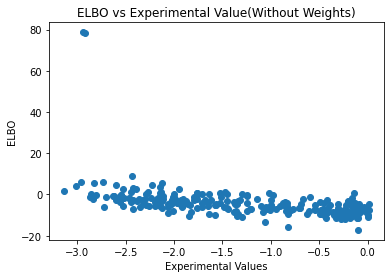

[6.60048736e-01 2.79999918e-34]


In [11]:
# Report the new Graph and Compare the Spearman Values
spearman_without_weights, exp_data_matrix, elbo_matrix = compute_spearman(model_no_weights, 1)
plot_elbo_exp(exp_data_matrix, elbo_matrix, '(Without Weights)')
print(spearman_without_weights)

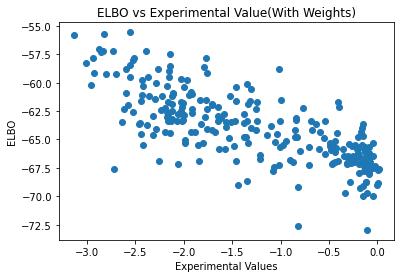

[7.63334371e-01 1.90823226e-51]


In [12]:
spearman_with_weights, exp_data_matrix, elbo_matrix = compute_spearman(model_weights, 1)
plot_elbo_exp(exp_data_matrix, elbo_matrix, '(With Weights)')
print(spearman_with_weights)


## Part 2. Extension


Computing Baseline Model with column independence

In [13]:
frequencies = np.zeros([263,23])

for sequence,_ in dataset_integers:
  i = 0
  for char in sequence:
    frequencies[i][char.item()] += 1
    i += 1

# The DataFrame shows the relative frequence of the differenct amino acids
# at the different positions of the sequence

frequencies_df = pd.DataFrame(frequencies/7844)
print(frequencies_df)


           0         1         2         3   ...        19   20   21        22
0    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.0  0.0  0.999873
1    0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.0  0.0  0.999873
2    0.000000  0.000000  0.000000  0.000127  ...  0.000000  0.0  0.0  0.999873
3    0.020653  0.000000  0.000000  0.000000  ...  0.000000  0.0  0.0  0.900561
4    0.014661  0.000000  0.017211  0.092682  ...  0.000000  0.0  0.0  0.666624
..        ...       ...       ...       ...  ...       ...  ...  ...       ...
258  0.188807  0.003187  0.000000  0.000000  ...  0.000000  0.0  0.0  0.125446
259  0.127104  0.003060  0.000000  0.000000  ...  0.170831  0.0  0.0  0.225778
260  0.000765  0.000000  0.188679  0.054054  ...  0.000000  0.0  0.0  0.707930
261  0.001020  0.000382  0.000000  0.001147  ...  0.000637  0.0  0.0  0.893549
262  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.0  0.0  0.928480

[263 rows x 23 columns]


134
0.00025497195308516065
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


Text(0, 0.5, 'frequency')

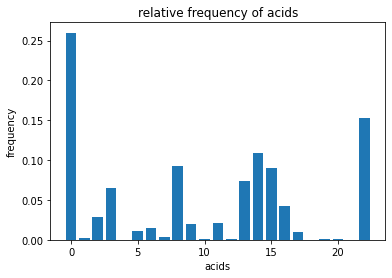

In [14]:
position = 0
value = 1
for i in range(263):
  if frequencies_df[22][i] <= value:
    value = frequencies_df[22][i]
    position = i

print(position)
print(value)

# Smallest value for 22
pos_134= frequencies[60]
x = np.arange(0,23,1)
print(x)

plt.bar(x, pos_134 / 7844, width=0.8)
plt.title('relative frequency of acids')
plt.xlabel('acids')
plt.ylabel('frequency')

In [15]:
position = 0
simple_mutations = np.zeros([263,23])
for char in wt_sequence:
  wt_prob = frequencies_df[char.item()][position]
  j = 0
  if wt_prob == 0:
    continue
  for mutant_to_prob in frequencies[position]:
    simple_mutations[position][j] = mutant_to_prob/wt_prob
    j+=1

  position +=1
    
simple_mean = simple_mutations.mean(1)
exp_data_matrix = np.array(experimental_data[experimental_data.columns]).astype(float)
exp_data_matrix = np.nanmean(exp_data_matrix, 1)
spearman_simple = stats.spearmanr( exp_data_matrix, simple_mean,nan_policy='omit' , axis = 0)
print(spearman_simple)

SpearmanrResult(correlation=0.5938022679929026, pvalue=1.8815608726821206e-26)


Importance Sampling


In [ ]:
# Own implementation of the variational autoencoder : 

torch.manual_seed(1)
cuda2 = False
device = torch.device("cuda" if cuda2 else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {}

epochs2 = 10 # About 20 is sufficent

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Since we use one-hot-encoding, the input dimension is 23 * 263 = 6049
        self.fc1 = nn.Linear(6049, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2
        self.fc3 = nn.Linear(2, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 6049)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        # Using torch.distributions
        return torch.distributions.normal.Normal(loc = self.fc21(h2), scale = torch.exp(0.5*self.fc22(h2)))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        gauss = self.encode(x.view(-1, 6049))
        # We sample z from the latent space using a Gaussian distribution
        z = gauss.rsample()
        return self.decode(z), gauss.mean, gauss.stddev


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    K = 10
    
    p_z = torch.distributions.normal.Normal(loc = mu, scale = torch.exp(logvar))
    zs = p_z.rsample(torch.tensor([K]))
    x_hat = model.decode(zs)
    
    BCE = torch.zeros(K)
    for ii in range(K):
        BCE[ii] = F.binary_cross_entropy(x_hat[ii], x.view(-1, 6049), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    ELBOs = BCE + KLD
    #following steps are to avoid computations of large exponenets
    max_elbo = max(ELBOs)
    ELBOs = torch.sub(ELBOs, max_elbo)
    ELBOs_exp = torch.exp(ELBOs)
    return torch.log( torch.sum(ELBOs_exp) / K ) + max_elbo

def train(epoch,model, weights_bool):
    model.train()
    train_loss = 0
    if weights_bool:
      dataloader = dataloader_with_weights
    else:
      dataloader = dataloader_no_weights
    
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))

In [ ]:
for epoch in range(1, epochs2 + 1):
    train(epoch, model, True)

====> Epoch: 1 Average loss: 739.1283
====> Epoch: 2 Average loss: 606.3397
====> Epoch: 3 Average loss: 592.6350
====> Epoch: 4 Average loss: 582.3386
====> Epoch: 5 Average loss: 578.6185
====> Epoch: 6 Average loss: 574.4918
====> Epoch: 7 Average loss: 575.3787
====> Epoch: 8 Average loss: 568.5975
====> Epoch: 9 Average loss: 570.6408
====> Epoch: 10 Average loss: 566.2219


[-66.67067553 -66.17789625 -67.52190897 -55.97536303 -74.2749103
 -73.36501412 -65.85272748 -58.36743164 -62.56640625 -65.89916196
 -63.4568163  -58.39111859 -64.31898565 -62.63643746 -62.58280878
 -60.98024584 -58.07381008 -59.92167066 -62.84995701 -55.34925643
 -61.6059358  -67.78053615 -63.62608271 -63.68671981 -61.47322945
 -62.77317744 -64.44690738 -62.5327573  -60.84765094 -65.9484306
 -63.88028087 -63.50610882 -63.20241912 -62.7149844  -61.56625234
 -59.82878046 -65.57296886 -64.63827117 -61.035549   -57.73166026
 -53.53171705 -59.71805473 -60.00680144 -63.4662794  -50.18015986
 -50.63522206 -55.1713708  -51.63263205 -57.90436056 -56.80145264
 -57.76062808 -53.94006348 -59.92740797 -61.98093315 -60.60288139
 -53.98208485 -63.30595332 -62.27444856 -59.00766655 -62.17504087
 -60.75088103 -62.03812309 -63.38276473 -64.58780836 -63.87855065
 -59.4114141  -62.18482772 -61.50363557 -62.96829622 -58.86341128
 -65.46698794 -60.40352199 -65.68851106 -64.49864396 -64.72406537
 -62.0411801

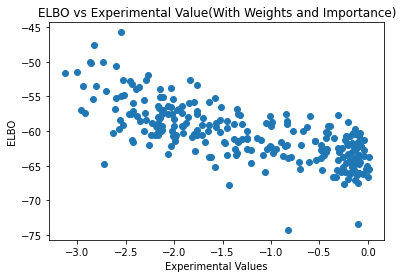

[7.36229593e-01 3.66051258e-46]


In [ ]:
spearman_with_weights_importance, exp_data_matrix, elbo_matrix = compute_spearman(model)
plot_elbo_exp(exp_data_matrix, elbo_matrix, '(With Weights and Importance)')
print(spearman_with_weights_importance)